# A/B Testing

## 1. Introduction

### 1.1 Problem Statement

An advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files.Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7. 

### 1.2 Objectives

The goal for this task is to maximize the following metrics:

* **Incremental Response Rate (IRR)**: which calculates how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion.
Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (treatment) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (control).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR):** how much is made (or lost) by sending out the promotion.
Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

## 2. Implementation

### 2.1 Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import f1_score, precision_score, recall_score

### 2.2 Load Data

In [3]:
train_df = pd.read_csv('training.csv', index_col = 'ID')
train_df.head()

,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
ID,,,,,,,,,
1,No,0,2,30.443518,-1.165083,1,1,3,2
3,No,0,3,32.159350,-0.645617,2,3,2,2
4,No,0,2,30.431659,0.133583,1,1,4,2
5,No,0,0,26.588914,-0.212728,2,1,4,2
8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84534 entries, 1 to 126184
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Promotion  84534 non-null  object 
 1   purchase   84534 non-null  int64  
 2   V1         84534 non-null  int64  
 3   V2         84534 non-null  float64
 4   V3         84534 non-null  float64
 5   V4         84534 non-null  int64  
 6   V5         84534 non-null  int64  
 7   V6         84534 non-null  int64  
 8   V7         84534 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 6.4+ MB


### 2.3 A/B Test

**Check Invariant Metric**

We first  check that the number of data points assigned to each group is similar. Should there be a statistically significant imbalance, the results would be biased.

We perform a two-sided test on the proportion of visitors assigned to one of our conditions.

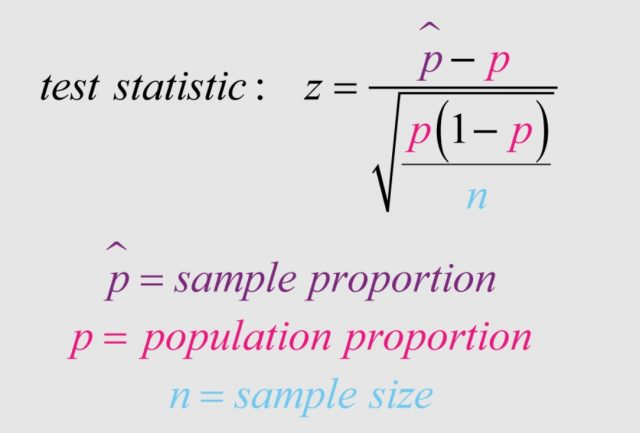

In [5]:
num_observations = len(train_df) 
num_observations

84534

In [6]:
num_control = len(train_df[train_df['Promotion']=='No'])
num_control

42170

In [7]:
p_hat = num_control/num_observations # proportion of visitors in control group
p_hat

0.4988525327087326

In [8]:
p = 0.5 # null hypothesis

In [9]:
# Compute Z-score
z_score = (p_hat - p)/np.sqrt((p*(1-p)/num_observations))
z_score

-0.6672460633167897

In [10]:
# Get p-value
p_value = 2 * stats.norm.cdf(z_score)
print('{0:0.3f}'.format(p_value))

0.505


In [11]:
# Alternative
stat, p_value = proportions_ztest(num_control, num_observations, p, alternative='two-sided')
print('{0:0.3f}'.format(p_value))

0.505


The p-value is higher than the commonly used significance level alpha = 0.05. This means that we fail to reject the null hypothesis, namely we cannot reject the hypothesis that p = 0.5, i.e. that the two groups have equal sizes. Thus our invariant metric has been validated.

**Result Tests**

In [12]:
promotion_group = train_df[train_df['Promotion'] == 'Yes']
n_promotion = promotion_group.shape[0]
print(promotion_group.shape)
print(n_promotion)

control_group = train_df[train_df['Promotion'] == 'No']
n_control = control_group.shape[0]
print(control_group.shape)
print(n_control)

(42364, 9)
42364
(42170, 9)
42170


In [13]:
perc_promotion_purch = train_df.loc[train_df['Promotion'] == 'Yes', 'purchase'].sum()/n_promotion
perc_control_purch  = train_df.loc[train_df['Promotion'] == 'No', 'purchase'].sum()/n_control

print(f'n_treat_purch: {perc_promotion_purch:.2%}')
print(f'n_ctrl_purch: {perc_control_purch:.2%}')

n_treat_purch: 1.70%
n_ctrl_purch: 0.76%


In [14]:
def get_eval_metrics(data, print_results=True):
    """Given a dataset, it computes the IRR and the NIR
    Arguments:
        data: pandas dataframe
        print_results: Bool for whether to print the metrics
    Returns:
        irr, nir: float"""
    n_treat       = data.loc[data['Promotion'] == 'Yes',:].shape[0]
    n_control     = data.loc[data['Promotion'] == 'No',:].shape[0]
    n_treat_purch = data.loc[data['Promotion'] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = data.loc[data['Promotion'] == 'No', 'purchase'].sum()
    
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = (10 * n_treat_purch - 0.15 * n_treat) - 10 * n_ctrl_purch
    
    if print_results==True:
        print(f'IRR: {irr:.4f}')
        print(f'NIR: {nir:.2f}') 
    
    return irr, nir

In [15]:
irr, nir = get_eval_metrics(train_df)

IRR: 0.0095
NIR: -2334.60
